In [40]:
from functions import util as util
from functions import event_parser as EvtParser
from functions import hit_parser as HitParser

import h5py
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import yaml
from matplotlib import colors

In [41]:
switch_xz = False
# module0, 2x2, 2x2_MR4, ndlar, singlecube
detector = "singlecube"

In [42]:
f = h5py.File('/Users/emoore06/Work/research/sclarpix_analysis/data/sc_muonshower_puritytest_larndsim.07.h5', 'r')
packets = f['packets'] # readout
segs = f['segments'] # Geant4 truth
assn = f['mc_packets_assn'] # G4-readout association
vtx = f['vertices']
traj = f['trajectories']

In [43]:
'''
    Loading LArPix geometry and run configuration
    Option 3: Build a LArPix geometry dictionary on the fly and load a run configuration yaml file
'''
from functions import geom_to_dict as DictBuilder
geom_repo = '/Users/emoore06/Work/research/sclarpix_analysis/config_repo'
larpix_layout_name = 'single_tile_layout-2.4.1'
geom_dict = DictBuilder.larpix_layout_to_dict(larpix_layout_name, geom_repo, save_dict=False)

run_config_path = '/Users/emoore06/Work/research/sclarpix_analysis/config_repo/singlecube.yaml'
run_config = util.get_run_config(run_config_path)

In [44]:
if switch_xz:
    tpc_centers_tp = np.array(run_config['tpc_offsets'])
    tpc_centers = np.copy(tpc_centers_tp)
    tpc_centers[:,0] = tpc_centers_tp[:,2]
    tpc_centers[:,2] = tpc_centers_tp[:,0]
else:
    tpc_centers = run_config['tpc_offsets']

In [45]:
pckt_event_ids = EvtParser.packet_to_eventid(assn, segs)
event_ids = EvtParser.get_eventid(vtx)
t0_grp = EvtParser.get_t0_event(vtx, run_config)

Found no 'beam_duration' in the configuration file


In [46]:
xyzdQevents = []
segevents = []
zvals = []
dQvals = []

for i_ev, evt_id in enumerate(event_ids):

    t0 = t0_grp[i_ev]
    evt_id = event_ids[i_ev]

    pckt_mask = pckt_event_ids == evt_id
    packets_ev = packets[pckt_mask]
    assn_ev = assn[pckt_mask]
    seg_ev = segs[segs['event_id'] == evt_id]
    
    x,y,z,dQ, v_drift_arr, t_drift_arr = HitParser.hit_parser_charge(t0, packets_ev, geom_dict, run_config, switch_xz)

    x = np.array(x) / 10. #Converting from mm to cm
    y = np.array(y) / 10. #Converting from mm to cm
    z = np.array(z) / 10. #Converting from mm to cm

    segevents.append(seg_ev)
    zvals.append(x) #x and z switched in larndsim :(
    dQvals.append(dQ)
    xyzdQevents.append((x,y,z,dQ))

In [47]:
def flatten(xss):
    return [x for xs in xss for x in xs]

dQflat = np.array(flatten(dQvals))
zflat = np.array(flatten(zvals))

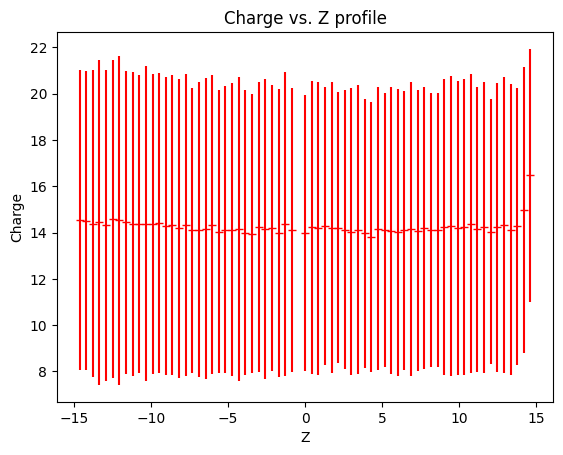

In [48]:
def compute_profile(x, y, nbin=(100,100)):
    
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

#compute the profile
p_x, p_mean, p_rms = compute_profile(zflat,dQflat,(70,70))

fig = plt.figure()
plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='r', color='r')
plt.xlabel("Z")
plt.ylabel("Charge")
plt.title("Charge vs. Z profile")
plt.show()

In [49]:
#Use scipy curve fit?